Companion Jupyter Notebook to the [MODIS Vegetation Indices: a GEE Approach](https://towardsdatascience.com/modis-vegetation-indices-a-gee-approach-f48e1259e462) article, published in Towards Data Science.

In [1]:
# installing everything
!pip install earthengine-api
!pip install folium 
!pip install geehydro
!pip install ipygee
!pip install proplot

  Created wheel for geehydro: filename=geehydro-0.1.5-py2.py3-none-any.whl size=10155 sha256=50143f157272f00ab8b418f758822ba0f506189ee12712a2ef84779c8a716a31
  Stored in directory: /root/.cache/pip/wheels/17/47/85/8a8750bc61aa125481bae0231f9c51e137ffa2955f3e60140c
Successfully built geehydro
     |████████████████████████████████| 2.8MB 6.5MB/s 
     |████████████████████████████████| 133kB 47.0MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 225kB 42.5MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.14-cp36-none-any.whl size=39897 sha256=e8c989afc837c616fd70f55bf3f83e2beff4bbed480f84d38ac179a7fcfd9a6d
  Stored in directory: /root/.cache/pip/wheels/57/f1/a2/ce9509a072ede592c0c9239ba66a1e9bb8af37bab3ca72fabc
  Created wheel for geetools: filename=geetools-0.4.15-cp36-none-any.whl size=98234 sha256=de2d713bac69f3360953b88de7b1f901eb908ad9235f0fa76fb50e4c0cc66ec8
  Stored in directory: /root/.cache/pip/wheels/a9/29/4b/8b23d7a814fd5b0

# Importing

In [0]:
import ee 
import folium
import geehydro
import numpy as np
import pandas as pd
import proplot as plot 
import matplotlib.pyplot as plt 

from ipygee import *
from pandas.plotting import register_matplotlib_converters

# Authentication

In [5]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=SZgmQMxUGUbtMrZ7wdTnjGMbuth4KOMzItUfpQ6mBN8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/xwEyf__VCgsKbPGCY1v-vfFM2wDASHfnJddvagD61kzNsnjhntqwtXI

Successfully saved authorization token.


# World Database on Protected Areas (WDPA)

In [0]:
wdpa_polygon = ee.FeatureCollection('WCMC/WDPA/current/polygons')
# select the Xingu Indigenous Park 
xingu = wdpa_polygon.filter(ee.Filter.eq('NAME', 'Parque do Xingu'))

In [0]:
#xingu.getInfo()

In [8]:
Map = folium.Map(location=[-12., -52.5], zoom_start=8)
#Map.setOptions('HYBRID')
Map.addLayer(xingu)
Map

# MODIS MOD13Q1 Vegetation Indices

In [0]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

In [0]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [0]:
def scale_factor(image):
  # scale factor for the MODIS MOD13Q1 product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

In [0]:
# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [13]:
# mean NDVI in the Xingu Park
# For EVI, just do scaled_evi_mean().clip(xingu)
Map.addLayer(scaled_ndvi.mean().clip(xingu),
             vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'yellow', 'green']})
Map

In [14]:
# Xingu MOD13Q1 NDVI time series
xingu_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': xingu,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
xingu_ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [0]:
#type(xingu_ndvi.dataframe)

In [19]:
# Xingu MOD13Q1 EVI time series
xingu_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                                   'region': xingu,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
xingu_evi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

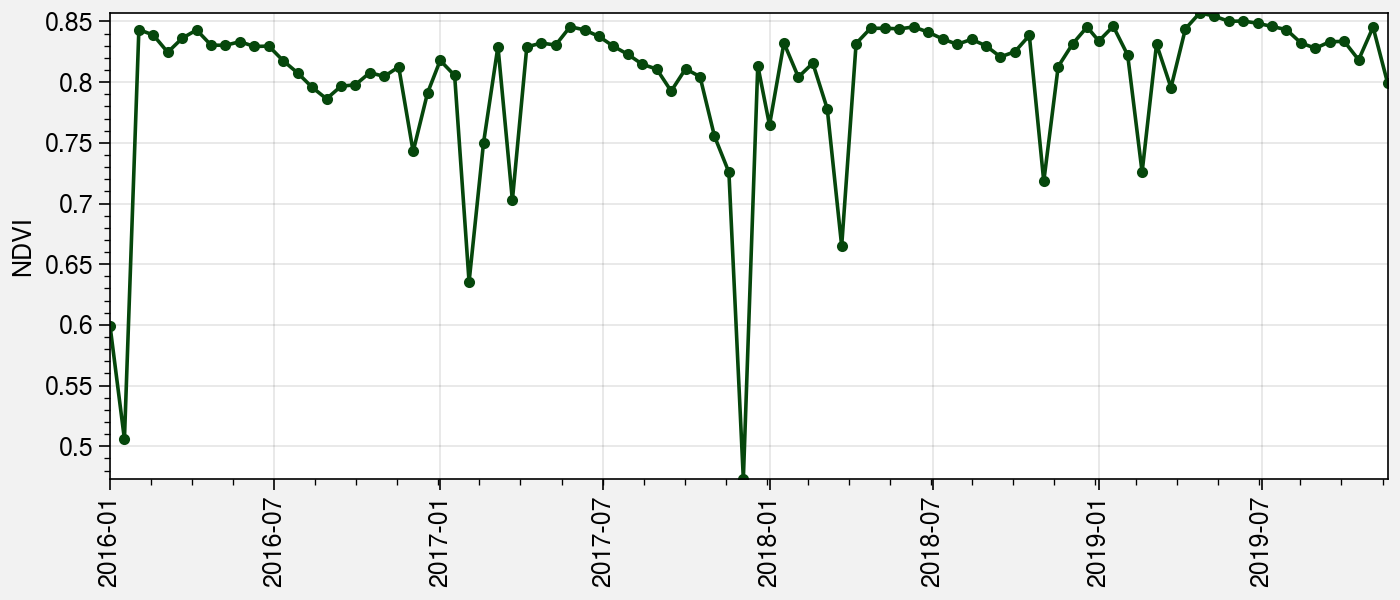

In [18]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(xingu_ndvi.dataframe.index, xingu_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')
plot.show()

In [0]:
# monthly averaging
xingu_evi_monthly = xingu_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
xingu_ndvi_monthly = xingu_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()

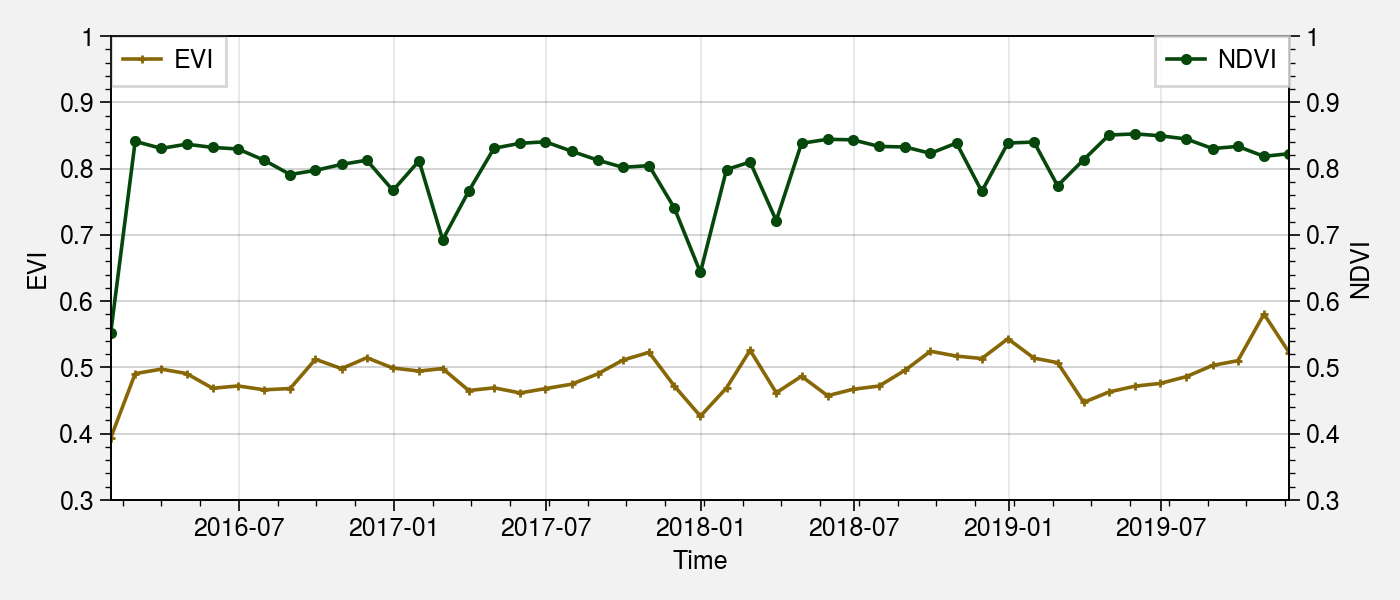

In [40]:
# time index 
time = xingu_evi_monthly.index

# plot
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()

ax1.plot(time, xingu_evi_monthly, label='EVI',
         color='muddy brown', marker='+')
ax2.plot(time, xingu_ndvi_monthly, label='NDVI',
         color='forest green', marker='o')

ax1.set_xlabel('Time')
ax1.set_ylabel('EVI')
ax2.set_ylabel('NDVI')

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()